<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/GenomicData_Final_Version_Deep_Unfolded_vqc_vs_vqc_qiskit_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
!pip install genomic-benchmarks

In [23]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)
print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the test set: {len(train_set)}")
from collections import defaultdict
import numpy as np


# Filter out sequences that consist entirely of "N"
filtered_data_set = [sample for sample in data_set if not all(base == 'N' for base in sample[0])]

print(f"Filtered data set size: {len(filtered_data_set)}")
print("One sample from the filtered data set:")
print(filtered_data_set[0])

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in filtered_data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1


print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)

import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]

np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]


from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensionality of the scaled data
pca = PCA(n_components=2)  # Reduce to 2 components; adjust this number as needed
sequences_pca = pca.fit_transform(sequences_scaled)

# Update the sequences in np_data_set with the PCA-transformed sequences
for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_pca[i]

# Shuffle the dataset again after transformation
np.random.shuffle(np_data_set)

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

np_train_data = np_data_set[:500]
np_test_data = np_data_set[-50:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

# Extract the PCA-transformed sequences and labels
train_sequences = np.array([data_point["sequence"] for data_point in np_train_data])
train_labels = np.array([data_point["label"] for data_point in np_train_data])

test_sequences = np.array([data_point["sequence"] for data_point in np_test_data])
test_labels = np.array([data_point["label"] for data_point in np_test_data])

print(f"Shape of reduced train_sequences: {train_sequences.shape}")
print(f"Shape of reduced test_sequences: {test_sequences.shape}")


Nuber of samples in the test set: 25000
Nuber of samples in the test set: 75000
Filtered data set size: 73118
One sample from the filtered data set:
('GAGAGGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTTGCCGATATGAAGGGAACTTTTCAGAAAGAGACCTACTCTGGGTCATTTAATTTTGAATACAGTTTTCAATCGTTCAAGTTTTGGATGGTTTATATCTAATGTGTGTTTCATTTTTTTGGAAAGCTATATTTTGTATTTAGGAAATGGTATACTATTTTGC', 0)

First 5 samples in the word_combinations dict.
GAGAGGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTT 1
AGAGGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTTG 2
GAGGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTTGC 3
AGGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTTGCC 4
GGCATTGAATTACGTTTTCAGTAGTACAGGCTTCTTGCCG 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:
Length of np_train_data: 500
Length of np_test_data: 50
Shape of reduced train_sequences: (500, 2)
Shape of reduced test_sequences: (50, 2)


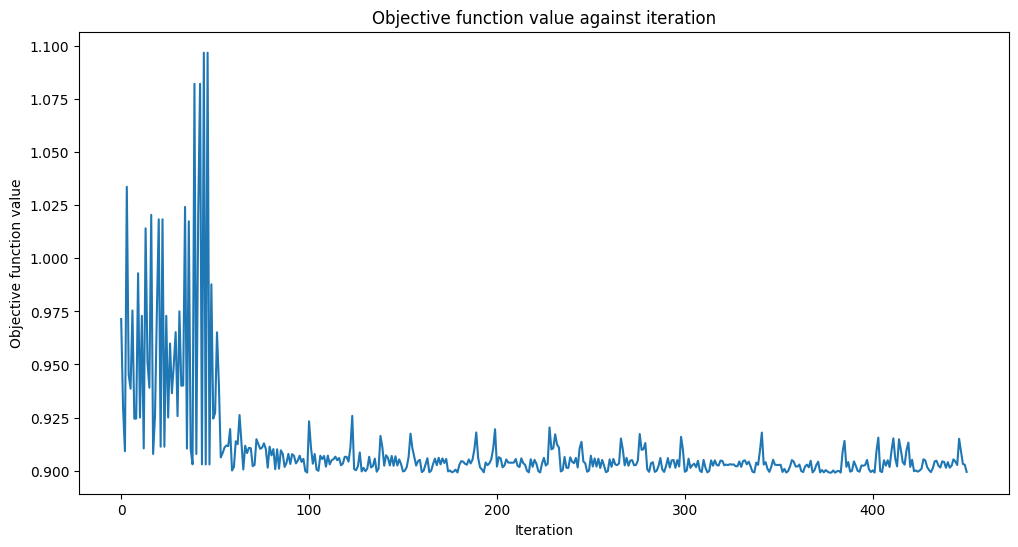

Training time: 522 seconds
Test Accuracy: 60.00%
Training Accuracy: 61.80%


In [24]:
from IPython.display import clear_output
clear_output()

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.utils import algorithm_globals

import numpy as np
import time
from matplotlib import pyplot as plt


# Setup feature map and ansatz for VQC
num_features = train_sequences.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

# Initialize optimizer and sampler
optimizer = SPSA(maxiter=200)
sampler = Sampler()

# Callback function for visualization
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Initialize VQC with the reduced feature map
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Train the model
start = time.time()
vqc.fit(train_sequences, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

# Get predictions and evaluate the model
test_predictions = vqc.predict(test_sequences)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Evaluate training accuracy
train_predictions = vqc.predict(train_sequences)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
predictions = vqc.predict(test_sequences[:4000])
true_labels = test_labels[:4000]

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision and Recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate F1-Score
f1 = f1_score(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")

# Calculate ROC-AUC Score
# Since it's a binary classification, directly pass the true labels and predictions
roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate a full classification report
report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)

Accuracy: 0.6000
Precision: 0.7333
Recall: 0.4074
F1 Score: 0.5238
ROC-AUC Score: 0.6167
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.83      0.66        23
           1       0.73      0.41      0.52        27

    accuracy                           0.60        50
   macro avg       0.64      0.62      0.59        50
weighted avg       0.65      0.60      0.58        50



Let's try to evaluate different featuremaps, datasets, and optimizers in following code for default qiskit.

In [ ]:


from IPython.display import clear_output
clear_output()

# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2022, 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
"""Helper functions to adjust number of qubits."""
from __future__ import annotations

from typing import Tuple

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap

from qiskit_machine_learning import QiskitMachineLearningError


# pylint: disable=invalid-name
def derive_num_qubits_feature_map_ansatz(
    num_qubits: int | None = None,
    feature_map: QuantumCircuit | None = None,
    ansatz: QuantumCircuit | None = None,
) -> Tuple[int, QuantumCircuit, QuantumCircuit]:
    """
    Derives a correct number of qubits, feature map, and ansatz from the parameters.

    If the number of qubits is not ``None``, then the feature map and ansatz are adjusted to this
    number of qubits if required. If such an adjustment fails, an error is raised. Also, if the
    feature map or ansatz or both are ``None``, then :class:`~qiskit.circuit.library.ZZFeatureMap`
    and :class:`~qiskit.circuit.library.RealAmplitudes` are created respectively. If there's just
    one qubit, :class:`~qiskit.circuit.library.ZFeatureMap` is created instead.

    If the number of qubits is ``None``, then the number of qubits is derived from the feature map
    or ansatz. Both the feature map and ansatz in this case must have the same number of qubits.
    If the number of qubits of the feature map is not the same as the number of qubits of
    the ansatz, an error is raised. If only one of the feature map and ansatz are ``None``, then
    :class:`~qiskit.circuit.library.ZZFeatureMap` or :class:`~qiskit.circuit.library.RealAmplitudes`
    are created respectively.

    If all the parameters are none an error is raised.

    Args:
        num_qubits: Number of qubits.
        feature_map: A feature map.
        ansatz: An ansatz.

    Returns:
        A tuple of number of qubits, feature map, and ansatz. All are not none.

    Raises:
        QiskitMachineLearningError: If correct values can not be derived from the parameters.
    """

    # check num_qubits, feature_map, and ansatz
    if num_qubits in (0, None) and feature_map is None and ansatz is None:
        raise QiskitMachineLearningError(
            "Need at least one of number of qubits, feature map, or ansatz!"
        )

    if num_qubits not in (0, None):
        if feature_map is not None:
            if feature_map.num_qubits != num_qubits:
                _adjust_num_qubits(feature_map, "feature map", num_qubits)
        else:
            feature_map = ZFeatureMap(num_qubits) if num_qubits == 1 else ZZFeatureMap(num_qubits)
        if ansatz is not None:
            if ansatz.num_qubits != num_qubits:
                _adjust_num_qubits(ansatz, "ansatz", num_qubits)
        else:
            ansatz = RealAmplitudes(num_qubits)
    else:
        if feature_map is not None and ansatz is not None:
            if feature_map.num_qubits != ansatz.num_qubits:
                raise QiskitMachineLearningError(
                    f"Mismatching number of qubits in the feature map ({feature_map.num_qubits}) "
                    f"and the ansatz ({ansatz.num_qubits})!"
                )
            num_qubits = feature_map.num_qubits
        elif feature_map is not None:
            num_qubits = feature_map.num_qubits
            ansatz = RealAmplitudes(num_qubits)
        else:
            num_qubits = ansatz.num_qubits
            feature_map = ZFeatureMap(num_qubits) if num_qubits == 1 else ZZFeatureMap(num_qubits)

    return num_qubits, feature_map, ansatz


def _adjust_num_qubits(circuit: QuantumCircuit, circuit_name: str, num_qubits: int) -> None:
    """
    Tries to adjust the number of qubits of the circuit by trying to set ``num_qubits`` properties.

    Args:
        circuit: A circuit to adjust.
        circuit_name: A circuit name, used in the error description.
        num_qubits: A number of qubits to set.

    Raises:
        QiskitMachineLearningError: if number of qubits can't be adjusted.

    """
    try:
        circuit.num_qubits = num_qubits
    except AttributeError as ex:
        raise QiskitMachineLearningError(
            f"The number of qubits {circuit.num_qubits} of the {circuit_name} does not match "
            f"the number of qubits {num_qubits}, and the {circuit_name} does not allow setting "
            "the number of qubits using `num_qubits`."
        ) from ex

"""An implementation of variational quantum classifier."""

from __future__ import annotations
from typing import Callable

import numpy as np

from qiskit import QuantumCircuit
from qiskit.primitives import BaseSampler

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import Optimizer, OptimizerResult, Minimizer
#from qiskit.utils import derive_num_qubits_feature_map_ansatz
from qiskit_machine_learning.utils.loss_functions import Loss

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

class VQC(NeuralNetworkClassifier):
    r"""A convenient Variational Quantum Classifier implementation.

    The variational quantum classifier (VQC) is a variational algorithm where the measured
    bitstrings are interpreted as the output of a classifier.

    Constructs a quantum circuit and corresponding neural network, then uses it to instantiate a
    neural network classifier.

    Labels can be passed in various formats, they can be plain labels, a one dimensional numpy
    array that contains integer labels like `[0, 1, 2, ...]`, or a numpy array with categorical
    string labels. One hot encoded labels are also supported. Internally, labels are transformed
    to one hot encoding and the classifier is always trained on one hot labels.

    Multi-label classification is not supported. E.g., :math:`[[1, 1, 0], [0, 1, 1], [1, 0, 1]]`.
    """

    def __init__(
        self,
        num_qubits: int | None = None,
        feature_map: QuantumCircuit | None = None,
        ansatz: QuantumCircuit | None = None,
        loss: str | Loss = "cross_entropy",
        optimizer: Optimizer | Minimizer | None = None,
        warm_start: bool = False,
        initial_point: np.ndarray | None = None,
        callback: Callable[[np.ndarray, float], None] | None = None,
        *,
        sampler: BaseSampler | None = None,
    ) -> None:
        """
        Args:
            num_qubits: The number of qubits for the underlying QNN.
                If ``None`` is given, the number of qubits is derived from the
                feature map or ansatz. If neither of those is given, raises an exception.
                The number of qubits in the feature map and ansatz are adjusted to this
                number if required.
            feature_map: The (parametrized) circuit to be used as a feature map for the underlying
                QNN. If ``None`` is given, the :class:`~qiskit.circuit.library.ZZFeatureMap`
                is used if the number of qubits is larger than 1. For a single qubit
                classification problem the :class:`~qiskit.circuit.library.ZFeatureMap`
                is used by default.
            ansatz: The (parametrized) circuit to be used as an ansatz for the underlying QNN.
                If ``None`` is given then the :class:`~qiskit.circuit.library.RealAmplitudes`
                circuit is used.
            loss: A target loss function to be used in training. Default value is ``cross_entropy``.
            optimizer: An instance of an optimizer or a callable to be used in training.
                Refer to :class:`~qiskit_algorithms.optimizers.Minimizer` for more information on
                the callable protocol. When `None` defaults to
                :class:`~qiskit_algorithms.optimizers.SLSQP`.
            warm_start: Use weights from previous fit to start next fit.
            initial_point: Initial point for the optimizer to start from.
            callback: a reference to a user's callback function that has two parameters and
                returns ``None``. The callback can access intermediate data during training.
                On each iteration an optimizer invokes the callback and passes current weights
                as an array and a computed value as a float of the objective function being
                optimized. This allows to track how well optimization / training process is going on.
            sampler: an optional Sampler primitive instance to be used by the underlying
                :class:`~qiskit_machine_learning.neural_networks.SamplerQNN` neural network. If
                ``None`` is passed then an instance of the reference Sampler will be used.
        Raises:
            QiskitMachineLearningError: Needs at least one out of ``num_qubits``, ``feature_map`` or
                ``ansatz`` to be given. Or the number of qubits in the feature map and/or ansatz
                can't be adjusted to ``num_qubits``.
        """

        num_qubits, feature_map, ansatz = derive_num_qubits_feature_map_ansatz(
            num_qubits, feature_map, ansatz
        )

        # construct circuit
        self._feature_map = feature_map
        self._ansatz = ansatz
        self._num_qubits = num_qubits
        self._circuit = QuantumCircuit(self._num_qubits)
        self._circuit.compose(self.feature_map, inplace=True)
        self._circuit.compose(self.ansatz, inplace=True)

        neural_network = SamplerQNN(
            sampler=sampler,
            circuit=self._circuit,
            input_params=self.feature_map.parameters,
            weight_params=self.ansatz.parameters,
            interpret=self._get_interpret(2),
            output_shape=2,
            input_gradients=False,
        )

        super().__init__(
            neural_network=neural_network,
            loss=loss,
            one_hot=True,
            optimizer=optimizer,
            warm_start=warm_start,
            initial_point=initial_point,
            callback=callback,
        )

    @property
    def feature_map(self) -> QuantumCircuit:
        """Returns the used feature map."""
        return self._feature_map

    @property
    def ansatz(self) -> QuantumCircuit:
        """Returns the used ansatz."""
        return self._ansatz

    @property
    def circuit(self) -> QuantumCircuit:
        """Returns the underlying quantum circuit."""
        return self._circuit

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits used by ansatz and feature map."""
        return self.circuit.num_qubits

    def _fit_internal(self, X: np.ndarray, y: np.ndarray) -> OptimizerResult:
        """
        Fit the model to data matrix X and targets y.

        Args:
            X: The input feature values.
            y: The input target values. Required to be one-hot encoded.

        Returns:
            Trained classifier.
        """
        X, y = self._validate_input(X, y)
        num_classes = self._num_classes

        # instance check required by mypy (alternative to cast)
        if isinstance(self._neural_network, SamplerQNN):
            self._neural_network.set_interpret(self._get_interpret(num_classes), num_classes)

        function = self._create_objective(X, y)
        return self._minimize(function)

    def _get_interpret(self, num_classes: int):
        def parity(x: int, num_classes: int = num_classes) -> int:
            return x % num_classes

        return parity

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import EfficientSU2, RealAmplitudes, TwoLocal
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, GradientDescent
from qiskit.primitives import Sampler
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.metrics import accuracy_score
import time

# Step 1: Choose the dataset
def choose_dataset():
    print("Choose the dataset: ")
    print("1. Iris")
    print("2. Wine")
    print("3. Breast Cancer")
    while True:
        try:
            dataset_choice = int(input("Enter the number corresponding to your choice: "))
            if dataset_choice in [1, 2, 3]:
                break
            else:
                print("Invalid choice, please select 1, 2, or 3.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    if dataset_choice == 1:
        dataset = load_iris()
        dataset_name = "Iris"
    elif dataset_choice == 2:
        dataset = load_wine()
        dataset_name = "Wine"
    elif dataset_choice == 3:
        dataset = load_breast_cancer()
        dataset_name = "Breast Cancer"

    return dataset, dataset_name

dataset, dataset_name = choose_dataset()

# Step 2: Prepare the dataset
features = dataset.data
labels = dataset.target
features = MinMaxScaler().fit_transform(features)

df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df["class"] = pd.Series(dataset.target)

# Step 3: Split the dataset
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Step 4: Choose the feature map
def choose_feature_map():
    print("Choose the feature map: ")
    print("1. ZZFeatureMap")
    print("2. ZFeatureMap")
    print("3. PauliFeatureMap")
    while True:
        try:
            feature_map_choice = int(input("Enter the number corresponding to your choice: "))
            if feature_map_choice in [1, 2, 3]:
                break
            else:
                print("Invalid choice, please select 1, 2, or 3.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    num_features = features.shape[1]

    if feature_map_choice == 1:
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        feature_map_name = "ZZFeatureMap"
    elif feature_map_choice == 2:
        feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
        feature_map_name = "ZFeatureMap"
    elif feature_map_choice == 3:
        feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
        feature_map_name = "PauliFeatureMap"

    return feature_map, feature_map_name

feature_map, feature_map_name = choose_feature_map()

# Step 5: Set the ansatz
# Step 5: Choose the ansatz
def choose_ansatz():
    print("Choose the ansatz: ")
    print("1. RealAmplitudes")
    print("2. EfficientSU2")
    print("3. TwoLocal")
    while True:
        try:
            ansatz_choice = int(input("Enter the number corresponding to your choice: "))
            if ansatz_choice in [1, 2, 3]:
                break
            else:
                print("Invalid choice, please select 1, 2, or 3.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    num_features = features.shape[1]

    if ansatz_choice == 1:
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        ansatz_name = "RealAmplitudes"
    elif ansatz_choice == 2:
        ansatz = EfficientSU2(num_qubits=num_features, reps=3)
        ansatz_name = "EfficientSU2"
    elif ansatz_choice == 3:
        ansatz = TwoLocal(num_qubits=num_features, reps=3)
        ansatz_name = "TwoLocal"

    return ansatz, ansatz_name

ansatz, ansatz_name = choose_ansatz()

# Step 6: Choose the optimizer
def choose_optimizer():
    print("Choose the optimizer: ")
    print("1. COBYLA")
    print("2. SPSA")
    print("3. ADAM")
    print("4. GradientDescent")
    while True:
        try:
            optimizer_choice = int(input("Enter the number corresponding to your choice: "))
            if optimizer_choice in [1, 2, 3, 4]:
                break
            else:
                print("Invalid choice, please select 1, 2, 3, or 4.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    if optimizer_choice == 1:
        optimizer = COBYLA(maxiter=100)
        optimizer_name = "COBYLA"
    elif optimizer_choice == 2:
        optimizer = SPSA(maxiter=60)
        optimizer_name = "SPSA"
    elif optimizer_choice == 3:
        optimizer = ADAM(maxiter=100)
        optimizer_name = "ADAM"
    elif optimizer_choice == 4:
        optimizer = GradientDescent(maxiter=100, learning_rate=0.01)
        optimizer_name = "GradientDescent"

    return optimizer, optimizer_name

optimizer, optimizer_name = choose_optimizer()

# Step 7: Initialize the sampler
sampler = Sampler()

# Step 8: Define the callback for visualization
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)

    # Dynamic title reflecting user choices
    plt.title(f"Objective function value - Dataset: {dataset_name}, "
              f"Feature Map: {feature_map_name}, Ansatz: {ansatz_name}, Optimizer: {optimizer_name}")

    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Step 9: Initialize the VQC
vqc = VQC(
    num_qubits=features.shape[1],
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Step 10: Reshape the train_features if necessary
train_features = train_features.reshape(-1, features.shape[1])

# Step 11: Train the VQC
objective_func_vals = []
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

# Step 12: Test the VQC
test_predictions = vqc.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

train_predictions = vqc.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


# **The following implementation shows how deep unfolding implement in vqc qiskit algorithm**

*   List item
*   List item



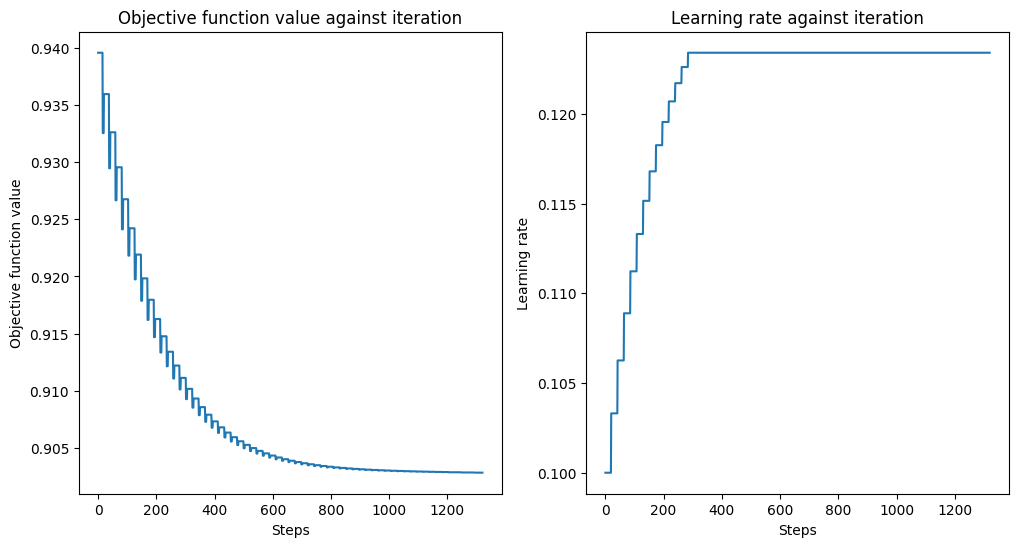

Training time: 1491 seconds
Test Accuracy Dvqc: 58.00%
Training Accuracy Dvqc: 59.20%


In [31]:
from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np

from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np

class DeepUnfoldingOptimizer(Optimizer):
    """
    Custom optimizer for deep unfolding with learnable learning rate.
    """
    def __init__(self, initial_lr=0.01, lr_alpha=0.01, maxiter=60, method="exp_decay", callback=None):
        self.lr = initial_lr  # Initialize learning rate
        self.maxiter = maxiter
        self.method = method #choose between exp_decay and gLR
        self.callback = callback  # Pass callback function
        self.lr_alpha = lr_alpha  # Meta-learning rate for gradient-based learning rate update

    def get_support_level(self):
        # Specifies support for gradient, bounds, and initial points
        return {
            "gradient": OptimizerSupportLevel.supported,
            "bounds": OptimizerSupportLevel.ignored,
            "initial_point": OptimizerSupportLevel.required,
        }

    def minimize(self, fun, x0, jac=None, bounds=None):
        """
        Minimization function that fits the signature expected by Qiskit optimizers.

        Args:
            fun: The objective function to minimize.
            x0: Initial point for optimization.
            jac: Gradient function (optional).
            bounds: Variable bounds (optional).

        Returns:
            OptimizerResult: Results of the optimization.
        """
        current_point = np.array(x0)
        for i in range(self.maxiter):
            # Compute gradient
            grad = self._compute_gradient(fun, current_point)

            # Update point using gradient and learnable learning rate
            current_point -= self.lr * grad

            # Compute gradient with respect to the learning rate
            grad_lr = self._compute_lr_gradient(fun, current_point, grad)

            # Adjust the learning rate based on the selected method
            if self.method == "exp_decay":
                # Exponential decay for learning rate
                self.lr *= 0.99
            elif self.method == "gLR":
                # Gradient-based learning rate adjustment
                grad_lr = self._compute_lr_gradient(fun, current_point, grad)
                self.lr -= self.lr_alpha * grad_lr

            # Optional callback for monitoring
            if self.callback:
                self.callback(current_point, fun(current_point))

        # Return the result in the format of OptimizerResult
        result = OptimizerResult()
        result.x = current_point
        result.fun = fun(current_point)
        return result

    def _compute_gradient(self, fun, point):
        epsilon = 1e-5
        grad = np.zeros(len(point))
        for i in range(len(point)):
            point_forward = point.copy()
            point_forward[i] += epsilon
            grad[i] = (fun(point_forward) - fun(point)) / epsilon
        return grad

    def _compute_lr_gradient(self, fun, point, grad):
        """
        Computes the gradient of the loss function with respect to the learning rate.
        This is approximated by considering how the change in the learning rate affects the loss.
        """
        # We use a finite difference approximation to compute dL/dlr
        epsilon_lr = 1e-5  # Small value for finite difference approximation
        lr_plus = self.lr + epsilon_lr
        lr_minus = self.lr - epsilon_lr

        # Update point with a small increment in learning rate
        point_plus = point - lr_plus * grad
        point_minus = point - lr_minus * grad

        # Approximate the gradient w.r.t. the learning rate
        grad_lr = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_lr)
        return grad_lr

# Define the feature map and ansatz
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split# Import the QuantumCircuit object
from qiskit.circuit import QuantumCircuit

# Setup feature map and ansatz for VQC
num_features = train_sequences.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)



# Custom optimizer with exponential decay for learning rate
#deep_unfolding_optimizer_exp = DeepUnfoldingOptimizer(initial_lr=0.1, maxiter=60, method="exp_decay", callback=callback_graph)

# Custom optimizer with gradient-based learning rate adjustment
deep_unfolding_optimizer_dLR = DeepUnfoldingOptimizer(initial_lr=0.1, maxiter=60, method="gLR", lr_alpha=0.1, callback=callback_graph)

# Callback to track learning progress
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
learning_rate_vals = []

plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    learning_rate_vals.append(deep_unfolding_optimizer_dLR.lr)

    plt.subplot(1, 2, 1)
    plt.title("Objective function value against iteration")
    plt.xlabel("Steps")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(1, 2, 2)
    plt.title("Learning rate against iteration")
    plt.xlabel("Steps")
    plt.ylabel("Learning rate")
    plt.plot(range(len(learning_rate_vals)), learning_rate_vals)

    plt.show()

# Initialize the VQC model with deep unfolding optimizer
from qiskit.primitives import Sampler
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_machine_learning.algorithms.classifiers import VQC
from typing import Callable, Optional, Union
from qiskit.primitives import StatevectorSampler, BaseSampler


sampler = Sampler()

class DeepUnfoldingVQC(VQC):
    """
    VQC integrated with deep unfolding for learning rate optimization.
    """
    def __init__(
        self,
        num_qubits: int | None = None,
        feature_map: QuantumCircuit | None = None,
        ansatz: QuantumCircuit | None = None,
        loss: str | Loss = "cross_entropy",
        optimizer: Optimizer | Callable | None = None,
        warm_start: bool = False,
        initial_point: np.ndarray | None = None,
        callback: Callable[[np.ndarray, float], None] | None = None,
        *,
        sampler: BaseSampler | None = None,
    ) -> None:
        super().__init__(
            num_qubits=num_qubits,
            feature_map=feature_map,
            ansatz=ansatz,
            loss=loss,
            optimizer=optimizer,
            warm_start=warm_start,
            initial_point=initial_point,
            callback=callback,
            sampler=sampler,
        )

# Clear objective value history
objective_func_vals = []
learning_rate_vals = []

# Instantiate VQC
dvqc = DeepUnfoldingVQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=deep_unfolding_optimizer_dLR,
    callback=callback_graph,
)

# Fit the model and time the training process
import time
start = time.time()
dvqc.fit(train_sequences, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


from sklearn.metrics import accuracy_score


# Get predictions and evaluate the model
test_predictions = dvqc.predict(test_sequences)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy Dvqc: {accuracy * 100:.2f}%")

# Evaluate training accuracy
train_predictions = dvqc.predict(train_sequences)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy Dvqc: {train_accuracy * 100:.2f}%")




with expn LR

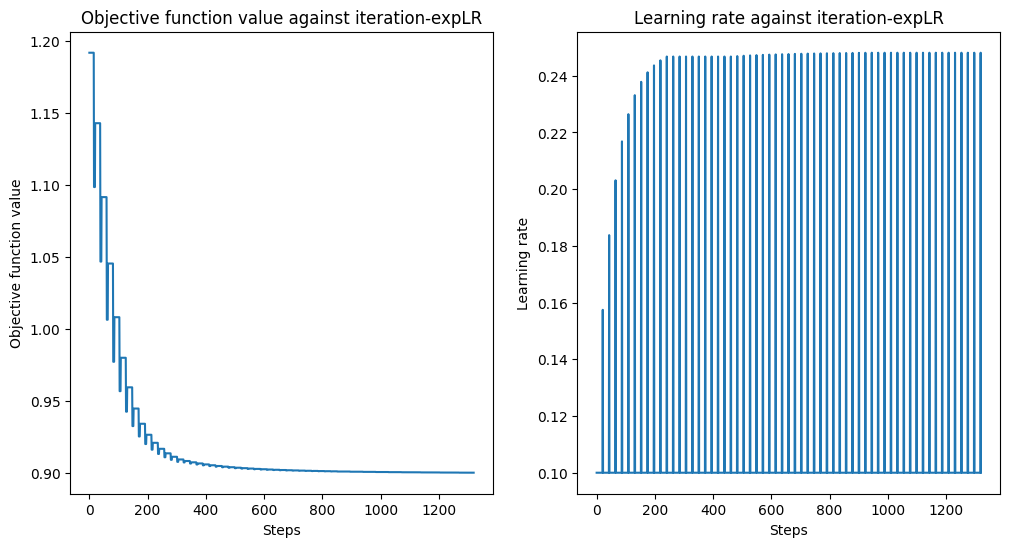

Training time: 1457 seconds
Test Accuracy Dvqc: 58.00%
Training Accuracy Dvqc: 62.40%


In [32]:
from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np

from qiskit_algorithms.optimizers import Optimizer, OptimizerSupportLevel, OptimizerResult
import numpy as np

class DeepUnfoldingOptimizer(Optimizer):
    """
    Custom optimizer for deep unfolding with learnable learning rate.
    """
    def __init__(self, initial_lr=0.01, lr_alpha=0.01, maxiter=60, method="exp_decay", callback=None):
        self.lr = initial_lr  # Initialize learning rate
        self.maxiter = maxiter
        self.method = method #choose between exp_decay and gLR
        self.callback = callback  # Pass callback function
        self.lr_alpha = lr_alpha  # Meta-learning rate for gradient-based learning rate update

    def get_support_level(self):
        # Specifies support for gradient, bounds, and initial points
        return {
            "gradient": OptimizerSupportLevel.supported,
            "bounds": OptimizerSupportLevel.ignored,
            "initial_point": OptimizerSupportLevel.required,
        }

    def minimize(self, fun, x0, jac=None, bounds=None):
        """
        Minimization function that fits the signature expected by Qiskit optimizers.

        Args:
            fun: The objective function to minimize.
            x0: Initial point for optimization.
            jac: Gradient function (optional).
            bounds: Variable bounds (optional).

        Returns:
            OptimizerResult: Results of the optimization.
        """
        current_point = np.array(x0)
        for i in range(self.maxiter):
            # Compute gradient
            grad = self._compute_gradient(fun, current_point)

            # Update point using gradient and learnable learning rate
            current_point -= self.lr * grad

            # Compute gradient with respect to the learning rate
            grad_lr = self._compute_lr_gradient(fun, current_point, grad)

            # Adjust the learning rate based on the selected method
            if self.method == "exp_decay":
                # Exponential decay for learning rate
                self.lr *= 0.99
            elif self.method == "gLR":
                # Gradient-based learning rate adjustment
                grad_lr = self._compute_lr_gradient(fun, current_point, grad)
                self.lr -= self.lr_alpha * grad_lr

            # Optional callback for monitoring
            if self.callback:
                self.callback(current_point, fun(current_point))

        # Return the result in the format of OptimizerResult
        result = OptimizerResult()
        result.x = current_point
        result.fun = fun(current_point)
        return result

    def _compute_gradient(self, fun, point):
        epsilon = 1e-5
        grad = np.zeros(len(point))
        for i in range(len(point)):
            point_forward = point.copy()
            point_forward[i] += epsilon
            grad[i] = (fun(point_forward) - fun(point)) / epsilon
        return grad

    def _compute_lr_gradient(self, fun, point, grad):
        """
        Computes the gradient of the loss function with respect to the learning rate.
        This is approximated by considering how the change in the learning rate affects the loss.
        """
        # We use a finite difference approximation to compute dL/dlr
        epsilon_lr = 1e-5  # Small value for finite difference approximation
        lr_plus = self.lr + epsilon_lr
        lr_minus = self.lr - epsilon_lr

        # Update point with a small increment in learning rate
        point_plus = point - lr_plus * grad
        point_minus = point - lr_minus * grad

        # Approximate the gradient w.r.t. the learning rate
        grad_lr = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_lr)
        return grad_lr

# Define the feature map and ansatz
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split# Import the QuantumCircuit object
from qiskit.circuit import QuantumCircuit

# Setup feature map and ansatz for VQC
num_features = train_sequences.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)



# Custom optimizer with exponential decay for learning rate
deep_unfolding_optimizer_exp = DeepUnfoldingOptimizer(initial_lr=0.1, maxiter=60, method="exp_decay", callback=callback_graph)

# Custom optimizer with gradient-based learning rate adjustment
#deep_unfolding_optimizer_dLR = DeepUnfoldingOptimizer(initial_lr=0.1, maxiter=60, method="gLR", lr_alpha=0.1, callback=callback_graph)

# Callback to track learning progress
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
learning_rate_vals = []

plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    learning_rate_vals.append(deep_unfolding_optimizer_exp.lr)

    plt.subplot(1, 2, 1)
    plt.title("Objective function value against iteration-expLR")
    plt.xlabel("Steps")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(1, 2, 2)
    plt.title("Learning rate against iteration-expLR")
    plt.xlabel("Steps")
    plt.ylabel("Learning rate")
    plt.plot(range(len(learning_rate_vals)), learning_rate_vals)

    plt.show()

# Initialize the VQC model with deep unfolding optimizer
from qiskit.primitives import Sampler
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_machine_learning.algorithms.classifiers import VQC
from typing import Callable, Optional, Union
from qiskit.primitives import StatevectorSampler, BaseSampler


sampler = Sampler()

class DeepUnfoldingVQC(VQC):
    """
    VQC integrated with deep unfolding for learning rate optimization.
    """
    def __init__(
        self,
        num_qubits: int | None = None,
        feature_map: QuantumCircuit | None = None,
        ansatz: QuantumCircuit | None = None,
        loss: str | Loss = "cross_entropy",
        optimizer: Optimizer | Callable | None = None,
        warm_start: bool = False,
        initial_point: np.ndarray | None = None,
        callback: Callable[[np.ndarray, float], None] | None = None,
        *,
        sampler: BaseSampler | None = None,
    ) -> None:
        super().__init__(
            num_qubits=num_qubits,
            feature_map=feature_map,
            ansatz=ansatz,
            loss=loss,
            optimizer=optimizer,
            warm_start=warm_start,
            initial_point=initial_point,
            callback=callback,
            sampler=sampler,
        )

# Clear objective value history
objective_func_vals = []
learning_rate_vals = []

# Instantiate VQC
dvqc = DeepUnfoldingVQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=deep_unfolding_optimizer_dLR,
    callback=callback_graph,
)

# Fit the model and time the training process
import time
start = time.time()
dvqc.fit(train_sequences, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


from sklearn.metrics import accuracy_score


# Get predictions and evaluate the model
test_predictions = dvqc.predict(test_sequences)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy Dvqc: {accuracy * 100:.2f}%")

# Evaluate training accuracy
train_predictions = dvqc.predict(train_sequences)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy Dvqc: {train_accuracy * 100:.2f}%")




In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
predictions = dvqc.predict(test_sequences[:4000])
true_labels = test_labels[:4000]

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision and Recall
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate F1-Score
f1 = f1_score(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")

# Calculate ROC-AUC Score
# Since it's a binary classification, directly pass the true labels and predictions
roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate a full classification report
report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)


Accuracy: 0.5800
Precision: 0.7500
Recall: 0.3333
F1 Score: 0.4615
ROC-AUC Score: 0.6014
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.87      0.66        23
           1       0.75      0.33      0.46        27

    accuracy                           0.58        50
   macro avg       0.64      0.60      0.56        50
weighted avg       0.65      0.58      0.55        50



In [ ]:
def moving_average(data, window_size=5):
    """Compute moving average for smoothing the curve."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Update the callback function with moving average smoothing
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    learning_rate_vals.append(deep_unfolding_optimizer.lr)

    # Apply moving average smoothing with window size of 5
    smoothed_obj_func_vals = moving_average(objective_func_vals, window_size=5)
    smoothed_learning_rate_vals = moving_average(learning_rate_vals, window_size=5)

    plt.subplot(1, 2, 1)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(smoothed_obj_func_vals)), smoothed_obj_func_vals)

    plt.subplot(1, 2, 2)
    plt.title("Learning rate against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Learning rate")
    plt.plot(range(len(smoothed_learning_rate_vals)), smoothed_learning_rate_vals)

    plt.show()


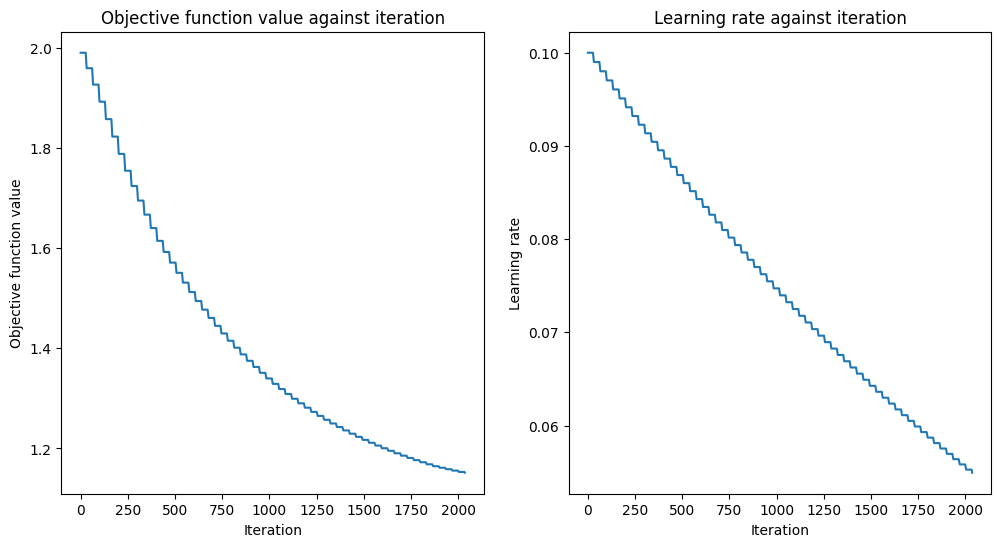

In [ ]:
# Apply moving average smoothing with window size of 5
smoothed_obj_func_vals = moving_average(objective_func_vals, window_size=5)
smoothed_learning_rate_vals = moving_average(learning_rate_vals, window_size=5)

plt.subplot(1, 2, 1)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(smoothed_obj_func_vals)), smoothed_obj_func_vals)

plt.subplot(1, 2, 2)
plt.title("Learning rate against iteration")
plt.xlabel("Iteration")
plt.ylabel("Learning rate")
plt.plot(range(len(smoothed_learning_rate_vals)), smoothed_learning_rate_vals)

plt.show()